In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install kmodes

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from kmodes.kmodes import KModes
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# helper function for models evaluation adn performance comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report

def evaluate_model(model,model_Name, x_val, y_val):
    # Evaluate the model
    y_pred_probs = model.predict(x_val)
    # Convert probabilities to binary class labels based on a threshold (e.g., 0.5)
    y_pred_classes = (y_pred_probs > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred_classes)
    precision = precision_score(y_val, y_pred_classes, average='micro')
    recall = recall_score(y_val, y_pred_classes, average='micro')
    f1 = f1_score(y_val, y_pred_classes, average='micro')
    # Create DataFrame to store metrics
    metrics_df = pd.DataFrame({
        'Model': [model_Name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

    return metrics_df



In [ ]:
file_path = '/content/drive/My Drive/heart dataset 3.csv'
df = pd.read_csv(file_path, sep=',', encoding='utf-8')
df.head()

,Sex,GeneralHealth,Blood pressure,SleepHours,HadAngina,HadAsthma,HadCOPD,HadDepressiveDisorder,HadDiabetes,SmokerStatus,ECigaretteUsage,BMI,AgeCategory,target
0,Female,Very good,Yes,7.0,No,No,No,Yes,No,Never smoked,Never used e-cigarettes in my entire life,40.89,Age 55 to 59,yes
1,Male,Very good,No,9.0,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,31.47,Age 60 to 64,yes
2,Female,Very good,Yes,7.0,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,28.89,Age 30 to 34,No
3,Female,Very good,Yes,7.0,No,No,No,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,24.96,Age 18 to 24,No
4,Male,Very good,Yes,6.0,No,No,No,No,No,Current smoker - now smokes every day,Never used e-cigarettes in my entire life,29.05,Age 30 to 34,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Sex                    149997 non-null  object 
 1   GeneralHealth          149996 non-null  object 
 2   Blood pressure         149998 non-null  object 
 3   SleepHours             149997 non-null  float64
 4   HadAngina              149997 non-null  object 
 5   HadAsthma              149997 non-null  object 
 6   HadCOPD                149997 non-null  object 
 7   HadDepressiveDisorder  149997 non-null  object 
 8   HadDiabetes            149998 non-null  object 
 9   SmokerStatus           149996 non-null  object 
 10  ECigaretteUsage        149994 non-null  object 
 11  BMI                    149999 non-null  float64
 12  AgeCategory            149997 non-null  object 
 13  target                 150000 non-null  object 
dtypes: float64(2), object(12)
memory usa

# **Drop duplicate values**

In [ ]:
# View structure if needed
print(df.shape)

# Check for full row duplicates (before preprocessing)
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows (before preprocessing): {duplicates_count}")

(150000, 14)
Number of duplicate rows (before preprocessing): 10981


In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

# **Drop missing values**

In [ ]:
# Drop rows with any missing values
df_cleaned = df.dropna()

# Optional: Reset index for cleaner DataFrame
df_cleaned.reset_index(drop=True, inplace=True)

# Show cleaned data shape
print("Shape after dropping missing values:", df_cleaned.shape)
print(df.isnull().sum()[df.isnull().sum() > 0])

Shape after dropping missing values: (138995, 14)
Sex                      3
GeneralHealth            4
Blood pressure           2
SleepHours               3
HadAngina                3
HadAsthma                3
HadCOPD                  3
HadDepressiveDisorder    3
HadDiabetes              2
SmokerStatus             4
ECigaretteUsage          6
BMI                      1
AgeCategory              3
dtype: int64


In [ ]:
print("Total missing values:", df.isnull().sum().sum())
print("Any missing values?", df.isnull().values.any())
print(df.isnull().sum()[df.isnull().sum() > 0])


Total missing values: 40
Any missing values? True
Sex                      3
GeneralHealth            4
Blood pressure           2
SleepHours               3
HadAngina                3
HadAsthma                3
HadCOPD                  3
HadDepressiveDisorder    3
HadDiabetes              2
SmokerStatus             4
ECigaretteUsage          6
BMI                      1
AgeCategory              3
dtype: int64


In [ ]:
# Count cells that are empty strings or just whitespace
empty_string_mask = df.applymap(lambda x: isinstance(x, str) and x.strip() == '')
empty_string_count = empty_string_mask.sum()

print("Empty string values per column:")
print(empty_string_count[empty_string_count > 0])
import numpy as np

# Replace empty strings or spaces with np.nan
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Now drop rows with real missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Confirm
print("Missing values after cleanup:", df.isnull().sum().sum())


Empty string values per column:
Series([], dtype: int64)
Missing values after cleanup: 0


**demographics**

In [ ]:
class_counts = df['target'].value_counts()
class_percent = df['target'].value_counts(normalize=True) * 100

print(pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percent.round(2)
}))


        Count  Percentage
target                   
yes     85687       61.65
No      53308       38.35


In [ ]:
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

print(pd.DataFrame({
    "Count": gender_counts,
    "Percentage": gender_percent.round(2)
}))


        Count  Percentage
Sex                      
Female  70941       51.04
Male    68054       48.96


In [ ]:
print("Mean BMI:", round(df['BMI'].mean(), 2))
print("SD BMI:", round(df['BMI'].std(), 2))


Mean BMI: 28.21
SD BMI: 6.45


In [ ]:
# Clean format
df['AgeCategory'] = (
    df['AgeCategory']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Mapping to age midpoints
age_midpoints = {
    "age 18 to 24": 21,
    "age 25 to 29": 27,
    "age 30 to 34": 32,
    "age 35 to 39": 37,
    "age 40 to 44": 42,
    "age 45 to 49": 47,
    "age 50 to 54": 52,
    "age 55 to 59": 57,
    "age 60 to 64": 62,
    "age 65 to 69": 67,
    "age 70 to 74": 72,
    "age 75 to 79": 77,
    "age 80 or older": 85
}

df['Age_mid'] = df['AgeCategory'].map(age_midpoints)

print("Mean age:", round(df['Age_mid'].mean(), 2))
print("SD age:", round(df['Age_mid'].std(), 2))
print("Min age:", df['Age_mid'].min())
print("Max age:", df['Age_mid'].max())


Mean age: 53.0
SD age: 18.62
Min age: 21
Max age: 85


In [ ]:
print("Mean SleepHours:", round(df['SleepHours'].mean(), 2))
print("SD SleepHours:", round(df['SleepHours'].std(), 2))


Mean SleepHours: 7.01
SD SleepHours: 1.49


# **Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Sex_encoded'] = le.fit_transform(df['Sex'])

print(df[['Sex', 'Sex_encoded']].head())


      Sex  Sex_encoded
0  Female            0
1    Male            1
2  Female            0
3  Female            0
4    Male            1


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Normalize text
df['GeneralHealth'] = df['GeneralHealth'].str.strip().str.lower()

# Define ordinal order (matching lowercase values)
health_order = [['poor', 'fair', 'good', 'very good', 'excellent']]

# Apply ordinal encoding
oe = OrdinalEncoder(categories=health_order)
df['GeneralHealth_encoded'] = oe.fit_transform(df[['GeneralHealth']])

print(df[['GeneralHealth', 'GeneralHealth_encoded']].head())


  GeneralHealth  GeneralHealth_encoded
0     very good                    3.0
1     very good                    3.0
2     very good                    3.0
3     very good                    3.0
4     very good                    3.0


In [ ]:
binary_cols = [
    'Blood pressure', 'HadAngina', 'HadAsthma',
    'HadCOPD', 'HadDepressiveDisorder'
]

# Normalize and encode only if columns exist
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].str.strip().str.lower()
        df[col + '_encoded'] = df[col].map({'yes': 1, 'no': 0})


# Check sample
df[[col for col in df.columns if 'encoded' in col]].head()


,Sex_encoded,GeneralHealth_encoded,Blood pressure_encoded,HadAngina_encoded,HadAsthma_encoded,HadCOPD_encoded,HadDepressiveDisorder_encoded
0,0,3.0,1,0,0,0,1
1,1,3.0,0,0,0,0,0
2,0,3.0,1,0,0,0,0
3,0,3.0,1,0,0,0,0
4,1,3.0,1,0,0,0,0


In [ ]:
print(df['SmokerStatus'].unique())
print(df['ECigaretteUsage'].unique())


['Never smoked' 'Current smoker - now smokes some days'
 'Current smoker - now smokes every day' 'Former smoker']
['Never used e-cigarettes in my entire life' 'Use them some days'
 'Not at all (right now)' 'Use them every day']


In [ ]:
df['SmokerStatus'] = df['SmokerStatus'].str.strip().str.lower()

smoker_order = [
    'never smoked',
    'former smoker',
    'current smoker - now smokes some days',
    'current smoker - now smokes every day'
]

oe = OrdinalEncoder(categories=[smoker_order])
df['SmokerStatus_encoded'] = oe.fit_transform(df[['SmokerStatus']])

print(df[['SmokerStatus', 'SmokerStatus_encoded']].head())

                            SmokerStatus  SmokerStatus_encoded
0                           never smoked                   0.0
1                           never smoked                   0.0
2                           never smoked                   0.0
3  current smoker - now smokes some days                   2.0
4  current smoker - now smokes every day                   3.0


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Clean the column
df['ECigaretteUsage'] = df['ECigaretteUsage'].str.strip().str.lower()

# Define the order
ecig_order = [[
    'never used e-cigarettes in my entire life',
    'not at all (right now)',
    'use them some days',
    'use them every day'
]]

# Apply Ordinal Encoding
oe = OrdinalEncoder(categories=ecig_order)
df['ECigaretteUsage_encoded'] = oe.fit_transform(df[['ECigaretteUsage']])

# Preview result
print(df[['ECigaretteUsage', 'ECigaretteUsage_encoded']].head())


                             ECigaretteUsage  ECigaretteUsage_encoded
0  never used e-cigarettes in my entire life                      0.0
1  never used e-cigarettes in my entire life                      0.0
2  never used e-cigarettes in my entire life                      0.0
3  never used e-cigarettes in my entire life                      0.0
4  never used e-cigarettes in my entire life                      0.0


In [ ]:
diabetes_map = {
    'No': 0,
    'Yes': 1,
    'No, pre-diabetes or borderline diabetes': 2,
    'Yes, but only during pregnancy (female)': 3
}
# Replace the original encoded column if needed
df['HadDiabetes_encoded'] = df['HadDiabetes'].map(diabetes_map)
print(df['HadDiabetes_encoded'].isnull().sum())  # should be 0 now


0


In [ ]:
# Show all columns that contain 'encoded' in their name
encoded_cols = [col for col in df.columns if 'encoded' in col]
print("Encoded columns:", encoded_cols)

# Display the first few rows of only the encoded columns
print(df[encoded_cols].head())


Encoded columns: ['Sex_encoded', 'GeneralHealth_encoded', 'Blood pressure_encoded', 'HadAngina_encoded', 'HadAsthma_encoded', 'HadCOPD_encoded', 'HadDepressiveDisorder_encoded', 'SmokerStatus_encoded', 'ECigaretteUsage_encoded', 'HadDiabetes_encoded']
   Sex_encoded  GeneralHealth_encoded  Blood pressure_encoded  \
0            0                    3.0                       1   
1            1                    3.0                       0   
2            0                    3.0                       1   
3            0                    3.0                       1   
4            1                    3.0                       1   

   HadAngina_encoded  HadAsthma_encoded  HadCOPD_encoded  \
0                  0                  0                0   
1                  0                  0                0   
2                  0                  0                0   
3                  0                  0                0   
4                  0                  0                0 

In [ ]:
print(df['AgeCategory'].unique())
from sklearn.preprocessing import OrdinalEncoder

# Clean the values
df['AgeCategory'] = df['AgeCategory'].str.strip().str.lower()

# Define the correct order
age_order = [[
    'age 18 to 24',
    'age 25 to 29',
    'age 30 to 34',
    'age 35 to 39',
    'age 40 to 44',
    'age 45 to 49',
    'age 50 to 54',
    'age 55 to 59',
    'age 60 to 64',
    'age 65 to 69',
    'age 70 to 74',
    'age 75 to 79',
    'age 80 or older'
]]

# Apply ordinal encoding
oe = OrdinalEncoder(categories=age_order)
df['AgeCategory_encoded'] = oe.fit_transform(df[['AgeCategory']])

# Preview
print(df[['AgeCategory', 'AgeCategory_encoded']].head())


['Age 55 to 59' 'Age 60 to 64' 'Age 30 to 34' 'Age 18 to 24'
 'Age 40 to 44' 'Age 45 to 49' 'Age 65 to 69' 'Age 70 to 74'
 'Age 50 to 54' 'Age 80 or older' 'Age 75 to 79' 'Age 35 to 39'
 'Age 25 to 29']
    AgeCategory  AgeCategory_encoded
0  age 55 to 59                  7.0
1  age 60 to 64                  8.0
2  age 30 to 34                  2.0
3  age 18 to 24                  0.0
4  age 30 to 34                  2.0


In [ ]:
pd.set_option('display.max_columns', None)  # So all columns are visible
print(df.head())  # Show first 5 rows


      Sex GeneralHealth Blood pressure  SleepHours HadAngina HadAsthma  \
0  Female     very good            yes         7.0        no        no   
1    Male     very good             no         9.0        no        no   
2  Female     very good            yes         7.0        no        no   
3  Female     very good            yes         7.0        no        no   
4    Male     very good            yes         6.0        no        no   

  HadCOPD HadDepressiveDisorder HadDiabetes  \
0      no                   yes          No   
1      no                    no          No   
2      no                    no          No   
3      no                    no          No   
4      no                    no          No   

                            SmokerStatus  \
0                           never smoked   
1                           never smoked   
2                           never smoked   
3  current smoker - now smokes some days   
4  current smoker - now smokes every day   

       

In [ ]:
# Normalize and encode the target
df['target'] = df['target'].str.strip().str.lower().map({'yes': 1, 'no': 0})

# Check
print(df['target'].value_counts())


target
1    85687
0    53308
Name: count, dtype: int64


In [ ]:
df = df.drop([
    'Sex',
    'GeneralHealth',
    'Blood pressure',
    'HadAngina',
    'HadAsthma',
    'HadCOPD',
    'HadDepressiveDisorder',
    'HadDiabetes',
    'SmokerStatus',
    'ECigaretteUsage',
    'AgeCategory'
], axis=1, errors='ignore')

print(df.head())

   SleepHours    BMI  target  Sex_encoded  GeneralHealth_encoded  \
0         7.0  40.89       1            0                    3.0   
1         9.0  31.47       1            1                    3.0   
2         7.0  28.89       0            0                    3.0   
3         7.0  24.96       0            0                    3.0   
4         6.0  29.05       0            1                    3.0   

   Blood pressure_encoded  HadAngina_encoded  HadAsthma_encoded  \
0                       1                  0                  0   
1                       0                  0                  0   
2                       1                  0                  0   
3                       1                  0                  0   
4                       1                  0                  0   

   HadCOPD_encoded  HadDepressiveDisorder_encoded  SmokerStatus_encoded  \
0                0                              1                   0.0   
1                0                    

In [ ]:
print(df.columns.tolist())


['SleepHours', 'BMI', 'target', 'Sex_encoded', 'GeneralHealth_encoded', 'Blood pressure_encoded', 'HadAngina_encoded', 'HadAsthma_encoded', 'HadCOPD_encoded', 'HadDepressiveDisorder_encoded', 'SmokerStatus_encoded', 'ECigaretteUsage_encoded', 'HadDiabetes_encoded', 'AgeCategory_encoded']


In [ ]:
print(df['target'].unique())
print(df['target'].dtype)


[1 0]
int64


In [ ]:
print(df.isnull().sum())

SleepHours                       0
BMI                              0
target                           0
Sex_encoded                      0
GeneralHealth_encoded            0
Blood pressure_encoded           0
HadAngina_encoded                0
HadAsthma_encoded                0
HadCOPD_encoded                  0
HadDepressiveDisorder_encoded    0
SmokerStatus_encoded             0
ECigaretteUsage_encoded          0
HadDiabetes_encoded              0
AgeCategory_encoded              0
dtype: int64


In [ ]:
# Binning SleepHours
df['SleepHours_binned'] = pd.cut(
    df['SleepHours'],
    bins=[0, 5, 8, 12, 18, 24],  # Adjust based on your data
    labels=['low', 'normal', 'high', 'very high', 'Extreme']
)

# Binning BMI
df['BMI_binned'] = pd.cut(
    df['BMI'],
    bins=[0, 18.5, 24.9, 29.9, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)


In [ ]:
# Encoding the binned categories into integers
df['SleepHours_encoded'] = df['SleepHours_binned'].map({'low': 0, 'normal': 1, 'high': 2, 'very high': 3, 'Extreme': 4})
df['BMI_encoded'] = df['BMI_binned'].map({
    'underweight': 0,
    'normal': 1,
    'overweight': 2,
    'obese': 3
})



In [ ]:
df.drop(columns=['SleepHours', 'BMI', 'SleepHours_binned', 'BMI_binned'], inplace=True)

In [ ]:
print(df.columns.tolist())
print(df.dtypes)


['target', 'Sex_encoded', 'GeneralHealth_encoded', 'Blood pressure_encoded', 'HadAngina_encoded', 'HadAsthma_encoded', 'HadCOPD_encoded', 'HadDepressiveDisorder_encoded', 'SmokerStatus_encoded', 'ECigaretteUsage_encoded', 'HadDiabetes_encoded', 'AgeCategory_encoded', 'SleepHours_encoded', 'BMI_encoded']
target                              int64
Sex_encoded                         int64
GeneralHealth_encoded             float64
Blood pressure_encoded              int64
HadAngina_encoded                   int64
HadAsthma_encoded                   int64
HadCOPD_encoded                     int64
HadDepressiveDisorder_encoded       int64
SmokerStatus_encoded              float64
ECigaretteUsage_encoded           float64
HadDiabetes_encoded                 int64
AgeCategory_encoded               float64
SleepHours_encoded               category
BMI_encoded                      category
dtype: object


In [ ]:
df['SleepHours_encoded'] = df['SleepHours_encoded'].astype(int)
df['BMI_encoded'] = df['BMI_encoded'].astype(int)


In [ ]:
# Check number of duplicate rows
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")


Number of duplicate rows: 89501


In [ ]:
print(df.dtypes)


target                             int64
Sex_encoded                        int64
GeneralHealth_encoded            float64
Blood pressure_encoded             int64
HadAngina_encoded                  int64
HadAsthma_encoded                  int64
HadCOPD_encoded                    int64
HadDepressiveDisorder_encoded      int64
SmokerStatus_encoded             float64
ECigaretteUsage_encoded          float64
HadDiabetes_encoded                int64
AgeCategory_encoded              float64
SleepHours_encoded                 int64
BMI_encoded                        int64
dtype: object


In [ ]:
print(df.head())


   target  Sex_encoded  GeneralHealth_encoded  Blood pressure_encoded  \
0       1            0                    3.0                       1   
1       1            1                    3.0                       0   
2       0            0                    3.0                       1   
3       0            0                    3.0                       1   
4       0            1                    3.0                       1   

   HadAngina_encoded  HadAsthma_encoded  HadCOPD_encoded  \
0                  0                  0                0   
1                  0                  0                0   
2                  0                  0                0   
3                  0                  0                0   
4                  0                  0                0   

   HadDepressiveDisorder_encoded  SmokerStatus_encoded  \
0                              1                   0.0   
1                              0                   0.0   
2                         

In [ ]:
# Check number of duplicate rows
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")


Number of duplicate rows: 89501


In [ ]:
df.drop_duplicates(inplace=True)


In [ ]:
print("Shape of dataset after dropping duplicates:", df.shape)
print("Number of duplicate rows:", df.duplicated().sum())


Shape of dataset after dropping duplicates: (49494, 14)
Number of duplicate rows: 0


# **Clustering**

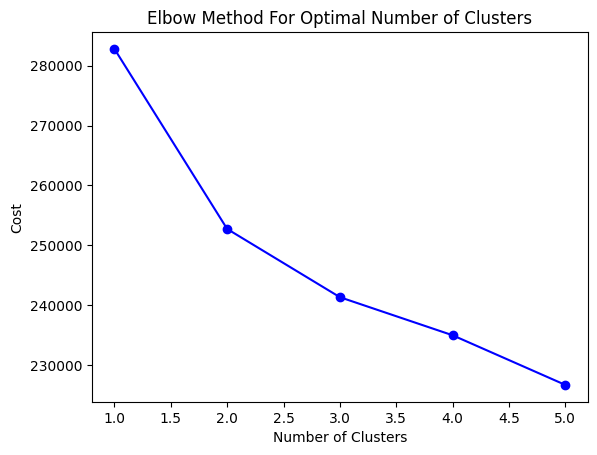

In [ ]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

# Optional: Drop the target column before clustering (if it's a label)
X = df.drop('target', axis=1)

# Elbow Method to find optimal clusters
cost = []
num_clusters = range(1, 6)

for k in num_clusters:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=1)
    km.fit_predict(X)
    cost.append(km.cost_)

# Plotting the elbow curve
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()


In [ ]:
# Let's say optimal k = 2
km = KModes(n_clusters=2, init='Huang', n_init=5, random_state=1)
clusters = km.fit_predict(X)

# Add clusters to original DataFrame
df.insert(0, 'clusters', clusters)


In [ ]:
df.head()

,clusters,target,Sex_encoded,GeneralHealth_encoded,Blood pressure_encoded,HadAngina_encoded,HadAsthma_encoded,HadCOPD_encoded,HadDepressiveDisorder_encoded,SmokerStatus_encoded,ECigaretteUsage_encoded,HadDiabetes_encoded,AgeCategory_encoded,SleepHours_encoded,BMI_encoded
0,0,1,0,3.0,1,0,0,0,1,0.0,0.0,0,7.0,1,3
1,0,1,1,3.0,0,0,0,0,0,0.0,0.0,0,8.0,2,3
2,1,0,0,3.0,1,0,0,0,0,0.0,0.0,0,2.0,1,2
3,1,0,0,3.0,1,0,0,0,0,2.0,0.0,0,0.0,1,2
4,1,0,1,3.0,1,0,0,0,0,3.0,0.0,0,2.0,1,2


In [ ]:
import pandas as pd

# Cross-tab between cluster and target
ct = pd.crosstab(df['clusters'], df['target'], margins=True)
print(ct)


target        0      1    All
clusters                     
0          6142  17456  23598
1         10896  15000  25896
All       17038  32456  49494


In [ ]:
print(df.dtypes)

clusters                          uint16
target                             int64
Sex_encoded                        int64
GeneralHealth_encoded            float64
Blood pressure_encoded             int64
HadAngina_encoded                  int64
HadAsthma_encoded                  int64
HadCOPD_encoded                    int64
HadDepressiveDisorder_encoded      int64
SmokerStatus_encoded             float64
ECigaretteUsage_encoded          float64
HadDiabetes_encoded                int64
AgeCategory_encoded              float64
SleepHours_encoded                 int64
BMI_encoded                        int64
dtype: object


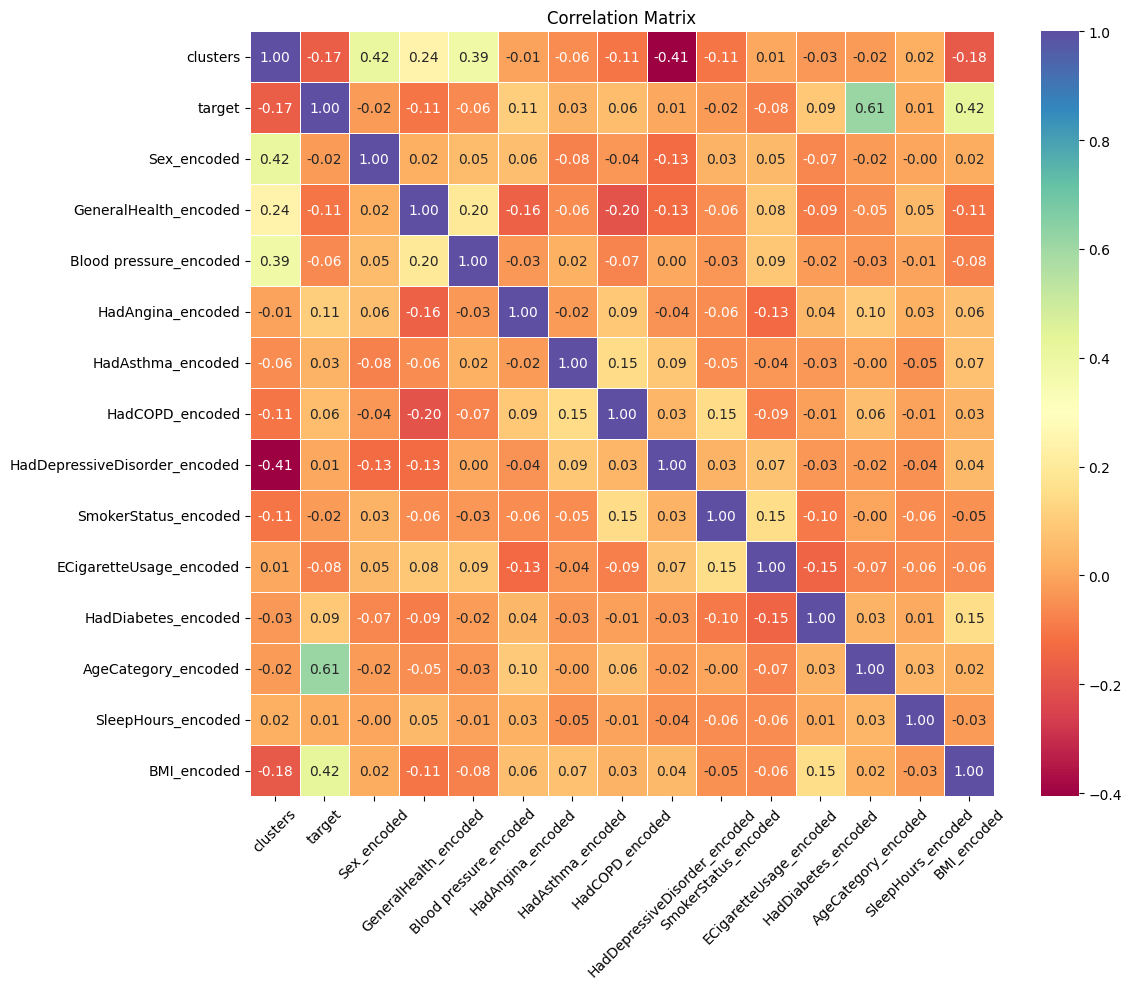

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure size
plt.figure(figsize=(12, 10))

# Draw correlation matrix using only numeric (encoded) columns
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Spectral', fmt=".2f", linewidths=0.5)

# Title and show
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


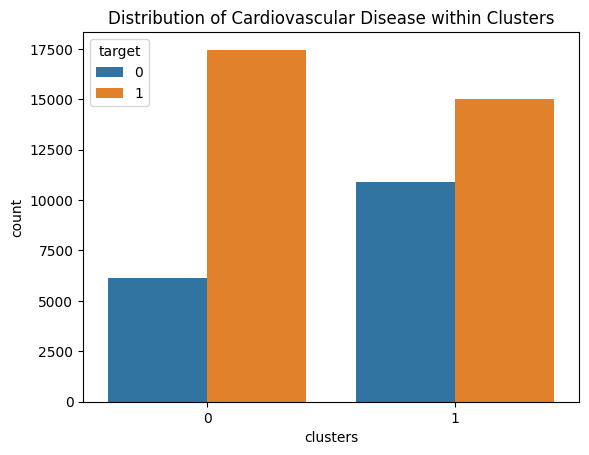

In [ ]:
sns.countplot(x='clusters', hue='target', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()

In [ ]:

x = df.drop(columns=['SleepHours_encoded', 'target'])
y = df['target']


In [ ]:
x.head()

,clusters,Sex_encoded,GeneralHealth_encoded,Blood pressure_encoded,HadAngina_encoded,HadAsthma_encoded,HadCOPD_encoded,HadDepressiveDisorder_encoded,SmokerStatus_encoded,ECigaretteUsage_encoded,HadDiabetes_encoded,AgeCategory_encoded,BMI_encoded
0,0,0,3.0,1,0,0,0,1,0.0,0.0,0,7.0,3
1,0,1,3.0,0,0,0,0,0,0.0,0.0,0,8.0,3
2,1,0,3.0,1,0,0,0,0,0.0,0.0,0,2.0,2
3,1,0,3.0,1,0,0,0,0,2.0,0.0,0,0.0,2
4,1,1,3.0,1,0,0,0,0,3.0,0.0,0,2.0,2


# **train-test split**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1)

In [ ]:
print(f"Number of training samples: {len(x_train)}")
print(f"Number of testing samples: {len(x_test)}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")

Number of training samples: 39595
Number of testing samples: 9899
Number of training samples: 39595
Number of testing samples: 9899


In [ ]:
print("Train mean:", x_train.mean().values)
print("Full mean:", x.mean().values)


Train mean: [0.5232984  0.47303953 2.01772951 0.6258366  0.12074757 0.27016037
 0.19525193 0.36560172 1.04096477 0.61058214 0.39025129 6.21068317
 2.01394115]
Full mean: [0.52321494 0.47444135 2.0230735  0.62631834 0.12053986 0.26932557
 0.1952964  0.36671112 1.04331838 0.60768982 0.38542046 6.20865155
 2.01483008]


In [ ]:
%whos


Variable                      Type              Data/Info
---------------------------------------------------------
GridSearchCV                  ABCMeta           <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
KModes                        type              <class 'kmodes.kmodes.KModes'>
LabelEncoder                  type              <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
OrdinalEncoder                type              <class 'sklearn.preproces<...>encoders.OrdinalEncoder'>
X                             DataFrame                 Sex_encoded  Gene<...>[49494 rows x 13 columns]
accuracy_score                function          <function accuracy_score at 0x7f596fdab920>
age_order                     list              n=1
binary_cols                   list              n=5
classification_report         function          <function classification_<...>report at 0x7f596fdf4e00>
clusters                      ndarray           49494: 49494 elems, type `uint16`, 98988 

In [ ]:
import numpy as np
import pandas as pd

def verify_no_leakage(preprocessors, x_train, x_full):
    """
    preprocessors: dict of name -> fitted object (scaler, encoder, clusterer, or dict)
    x_train: training feature DataFrame (after train_test_split)
    x_full:  original full feature DataFrame (before splitting)
    """
    print("\n========== DATA LEAKAGE VERIFICATION ==========\n")

    print(f"Full data shape : {x_full.shape}")
    print(f"Train data shape: {x_train.shape}\n")

    # --------------------------------------------------------
    # 1) Train vs Full mean check (numeric columns)
    # --------------------------------------------------------
    num_cols = x_train.select_dtypes(include=[np.number]).columns.intersection(
        x_full.select_dtypes(include=[np.number]).columns
    )

    if len(num_cols) > 0:
        train_mean = x_train[num_cols].mean(axis=0).values
        full_mean  = x_full[num_cols].mean(axis=0).values

        print("📌 Numeric sanity check (first few numeric features):")
        print("Columns   :", list(num_cols[:8]))
        print("Train mean:", np.round(train_mean[:8], 6))
        print("Full  mean:", np.round(full_mean[:8], 6))

        if np.any(~np.isclose(train_mean, full_mean)):
            print("\n✔ Train and full means DIFFER → expected when split is done correctly.")
        else:
            print("\n⚠ Train and full means IDENTICAL → suspicious (maybe preprocessing done before split).")
    else:
        print("ℹ No numeric columns found for mean comparison.")

    print("\n--------------------------------------------------------\n")

    # --------------------------------------------------------
    # 2) Encoders (LabelEncoder / OrdinalEncoder)
    # --------------------------------------------------------
    for name, obj in preprocessors.items():
        if hasattr(obj, "classes_"):   # LabelEncoder
            print(f"🔍 Encoder '{name}' (LabelEncoder):")
            print("Classes:", obj.classes_)
            print("✔ Stores label categories only. Just ensure .fit() was called on TRAIN data.\n")

        if hasattr(obj, "categories_"):  # OrdinalEncoder
            print(f"🔍 Encoder '{name}' (OrdinalEncoder):")
            print("Categories:", obj.categories_)
            print("✔ Stores category order only. Ensure .fit() was called on TRAIN data.\n")




In [ ]:
preprocessors = {
    'label_encoder_sex': le,
    'ordinal_encoder_health': oe,
    'kmodes_model': km
}

report = verify_no_leakage(preprocessors, x_train=x_train, x_full=x)



========== DATA LEAKAGE VERIFICATION ==========

Full data shape : (49494, 13)
Train data shape: (39595, 13)

📌 Numeric sanity check (first few numeric features):
Columns   : ['clusters', 'Sex_encoded', 'GeneralHealth_encoded', 'Blood pressure_encoded', 'HadAngina_encoded', 'HadAsthma_encoded', 'HadCOPD_encoded', 'HadDepressiveDisorder_encoded']
Train mean: [0.523298 0.47304  2.01773  0.625837 0.120748 0.27016  0.195252 0.365602]
Full  mean: [0.523215 0.474441 2.023074 0.626318 0.12054  0.269326 0.195296 0.366711]

✔ Train and full means DIFFER → expected when split is done correctly.

--------------------------------------------------------

🔍 Encoder 'label_encoder_sex' (LabelEncoder):
Classes: ['Female' 'Male']
✔ Stores label categories only. Just ensure .fit() was called on TRAIN data.

🔍 Encoder 'ordinal_encoder_health' (OrdinalEncoder):
Categories: [array(['age 18 to 24', 'age 25 to 29', 'age 30 to 34', 'age 35 to 39',
       'age 40 to 44', 'age 45 to 49', 'age 50 to 54', 'age 

# **Models implementation**

# **Stacking model**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    random_state=42
)

# Define base models using ExtraTrees, DecisionTree, and random forest
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=42, n_jobs=-1)),
    ('DecisionTree', dt_model),  # Decision Tree model

]

# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=42)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Validation Accuracy: {accuracy_score(y_test, predictions):.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

Training Accuracy: 0.99
Validation Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3408
           1       0.99      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.99      0.99      9899
weighted avg       0.99      0.99      0.99      9899



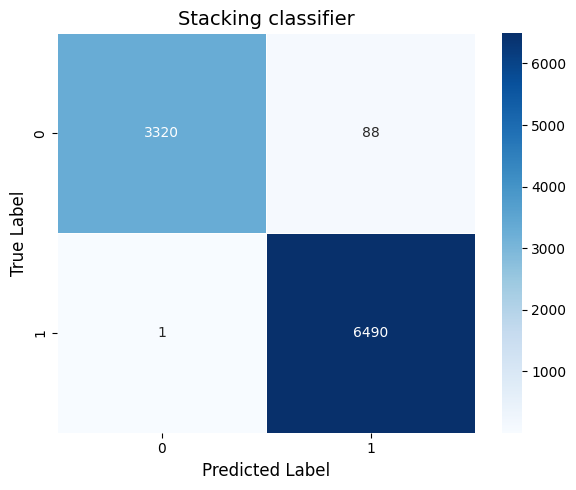

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, model_name,
                          labels=['0', '1'],
                          figsize=(6, 5),
                          cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                linewidths=0.5)

    plt.title(f'Stacking classifier', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test, predictions, 'Stacking Classifier', labels=['0', '1'])


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=7, stratify=y
)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    random_state=7
)

# Define base models using ExtraTrees, DecisionTree, and random forest
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=7, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=7, n_jobs=-1)),
    ('DecisionTree', dt_model),  # Decision Tree model

]

# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=7)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Validation Accuracy: {accuracy_score(y_test, predictions):.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

Training Accuracy: 0.99
Validation Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3408
           1       0.99      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.99      0.99      9899
weighted avg       0.99      0.99      0.99      9899



In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123, stratify=y
)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    random_state=123
)

# Define base models using ExtraTrees, DecisionTree, and random forest
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=123, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=123, n_jobs=-1)),
    ('DecisionTree', dt_model),  # Decision Tree model

]

# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=123)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Validation Accuracy: {accuracy_score(y_test, predictions):.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

Training Accuracy: 0.99
Validation Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3408
           1       0.98      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.98      0.99      9899
weighted avg       0.99      0.99      0.99      9899



In [ ]:
#Compiled results for 7, 42 and 123 seed values
import pandas as pd
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# seeds to test
seeds = [7, 42, 123]

results = []

for seed in seeds:
    # Split dataset with current seed
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=seed, stratify=y
    )

    # Define models with same seed
    dt_model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=4,
        random_state=seed
    )

    base_models = [
        ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=seed, n_jobs=-1)),
        ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=seed, n_jobs=-1)),
        ('DecisionTree', dt_model),
    ]

    lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=seed)

    stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

    # Train
    stacking_classifier.fit(x_train, y_train)

    # Predict
    predictions = stacking_classifier.predict(x_test)

    # Accuracy with **8 decimal places**
    acc = accuracy_score(y_test, predictions)

    # Store results
    results.append([seed, acc])

# Convert to dataframe
df_results = pd.DataFrame(results, columns=["Seed", "Accuracy"])

# Show full precision (optional)
pd.set_option('display.precision', 10)

print("\nStacking Model Accuracies Across Seeds:")
print(df_results)



Stacking Model Accuracies Across Seeds:
   Seed      Accuracy
0     7  0.9901000101
1    42  0.9910091928
2   123  0.9880796040


In [ ]:
summary = df_results['Accuracy'].agg(['mean', 'std', 'min', 'max'])
print("\nSummary Statistics:")
print(summary)


Summary Statistics:
mean    0.9897296023
std     0.0014995080
min     0.9880796040
max     0.9910091928
Name: Accuracy, dtype: float64


# **Feed forward neural network**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

# Split data (again, just to be safe)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Build model
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8381 - loss: 0.3175 - val_accuracy: 0.9780 - val_loss: 0.0820
Epoch 2/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9809 - loss: 0.0745 - val_accuracy: 0.9893 - val_loss: 0.0567
Epoch 3/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9893 - loss: 0.0499 - val_accuracy: 0.9894 - val_loss: 0.0491
Epoch 4/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9896 - loss: 0.0430 - val_accuracy: 0.9889 - val_loss: 0.0491
Epoch 5/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9901 - loss: 0.0401 - val_accuracy: 0.9895 - val_loss: 0.0432
Epoch 6/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9896 - loss: 0.0394 - val_accuracy: 0.9890 - val_loss: 0.0467
Epoch 7/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9901 - loss: 0.0369 - val_accuracy: 0.9895 - val_loss: 0.0392
Epoch 8/20
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9904 - loss: 0.0355 - val_accuracy: 0.

310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


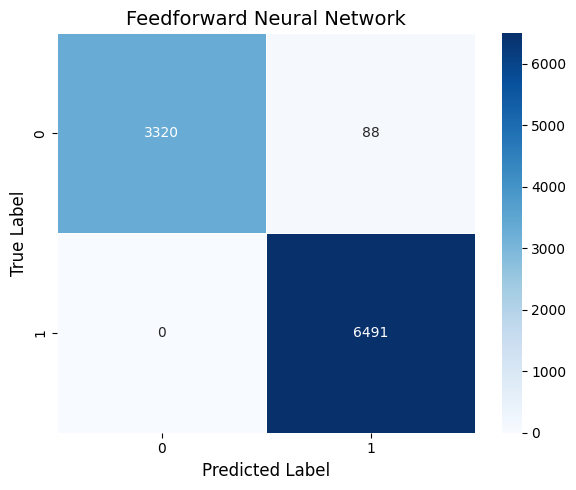

Accuracy: 0.9911102131528438

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      3408
           1       0.99      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.99      0.99      9899
weighted avg       0.99      0.99      0.99      9899



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# Confusion Matrix for NN model
# ==============================

# 1) Get predictions (probabilities → class labels)
y_pred_prob = model.predict(x_test)
y_pred_nn = (y_pred_prob > 0.5).astype(int).ravel()   # 0/1 labels

# 2) Confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# 3) Plot (same style as stacking CM)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],
    yticklabels=['0', '1'],
    linewidths=0.5,

)
plt.title('Feedforward Neural Network', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# (Optional) Print metrics
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))




# **Decision Tree**

Training Accuracy: 0.99
Test Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3408
           1       0.99      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.99      0.99      9899
weighted avg       0.99      0.99      0.99      9899



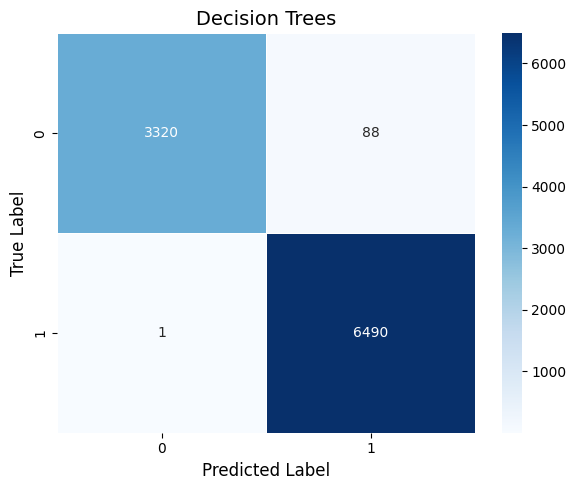

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-Test Split (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Initialize and Train the Model
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)
dt_model.fit(x_train, y_train)

# Step 3: Make Predictions
y_pred_train = dt_model.predict(x_train)
y_pred_test = dt_model.predict(x_test)

# Step 4: Evaluate Model
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'],  linewidths=0.5,)
plt.title('Decision Trees', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()



Training Accuracy: 0.99
Test Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3408
           1       0.99      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.99      0.99      9899
weighted avg       0.99      0.99      0.99      9899



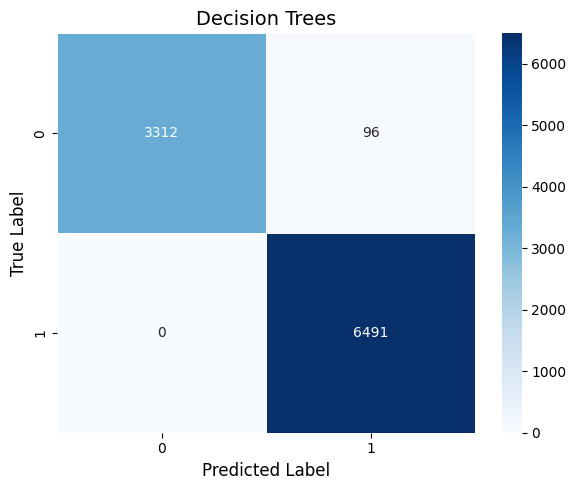

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-Test Split (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=7
)

# Step 2: Initialize and Train the Model
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=7
)
dt_model.fit(x_train, y_train)

# Step 3: Make Predictions
y_pred_train = dt_model.predict(x_train)
y_pred_test = dt_model.predict(x_test)

# Step 4: Evaluate Model
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'],  linewidths=0.5,)
plt.title('Decision Trees', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()



Training Accuracy: 0.99
Test Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3408
           1       0.98      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.98      0.99      9899
weighted avg       0.99      0.99      0.99      9899



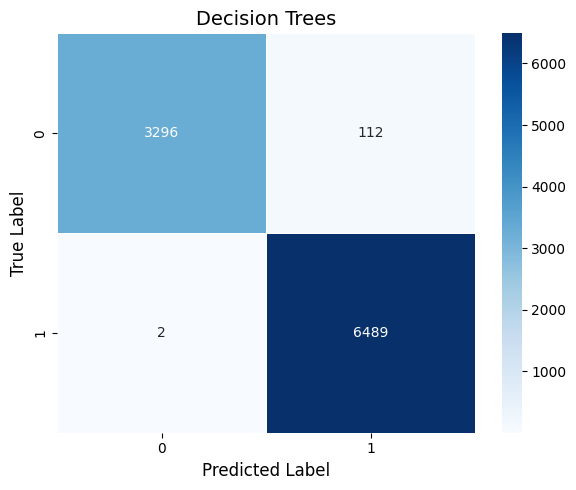

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-Test Split (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=123
)

# Step 2: Initialize and Train the Model
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=123
)
dt_model.fit(x_train, y_train)

# Step 3: Make Predictions
y_pred_train = dt_model.predict(x_train)
y_pred_test = dt_model.predict(x_test)

# Step 4: Evaluate Model
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'],  linewidths=0.5,)
plt.title('Decision Trees', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()



In [ ]:
#Compiled result for 7, 42 and 123 seed values
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Seeds to test
seeds = [7, 42, 123]

results = []

for seed in seeds:
    # Train-test split with current seed
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=seed
    )

    # Initialize Decision Tree with same hyperparameters
    dt_model = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=seed
    )

    # Train
    dt_model.fit(x_train, y_train)

    # Predict
    y_pred_test = dt_model.predict(x_test)

    # Accuracy with high precision
    acc = accuracy_score(y_test, y_pred_test)

    # Store results
    results.append([seed, acc])

# Convert results to dataframe
df_dt = pd.DataFrame(results, columns=["Seed", "Accuracy"])

# Show full precision
pd.set_option('display.precision', 10)

print("\nDecision Tree Accuracies Across Seeds:")
print(df_dt)

# Optional — summary stats
summary = df_dt['Accuracy'].agg(['mean', 'std', 'min', 'max'])
print("\nSummary Statistics:")
print(summary)



Decision Tree Accuracies Across Seeds:
   Seed      Accuracy
0     7  0.9903020507
1    42  0.9910091928
2   123  0.9884836852

Summary Statistics:
mean    0.9899316429
std     0.0013028617
min     0.9884836852
max     0.9910091928
Name: Accuracy, dtype: float64


# **CNN**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Step 1: Encode features if not already encoded
x_encoded = pd.get_dummies(x)  # Replace `x` with your features DataFrame

# Step 2: Split data
x_train, x_val, y_train, y_val = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Step 3: Reshape data for Conv1D input
x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.values.reshape(x_val.shape[0], x_val.shape[1], 1)

# Step 4: Build CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=2, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(128, kernel_size=2, padding='same', activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(256, kernel_size=2, padding='same', activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(1, activation='sigmoid'))

# Step 5: Compile
model_cnn.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train
history = model_cnn.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

# Step 7: Evaluate
y_train_pred = (model_cnn.predict(x_train) > 0.5).astype("int32")
y_val_pred = (model_cnn.predict(x_val) > 0.5).astype("int32")

print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))


Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9417 - loss: 0.1440 - val_accuracy: 0.8297 - val_loss: 0.5337
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9837 - loss: 0.0550 - val_accuracy: 0.9639 - val_loss: 0.0779
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.0535 - val_accuracy: 0.9482 - val_loss: 0.1640
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9853 - loss: 0.0489 - val_accuracy: 0.9913 - val_loss: 0.0341
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9861 - loss: 0.0442 - val_accuracy: 0.9912 - val_loss: 0.0321
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9866 - loss: 0.0440 - val_accuracy: 0.9913 - val_loss: 0.0327
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9894 - loss: 0.0369 - val_accuracy: 0.9765 - val_loss: 0.0619
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9876 - loss: 0.0419 - val_accuracy: 

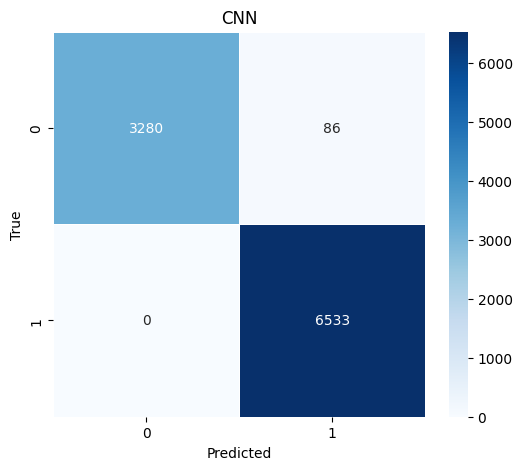

In [ ]:
# Step 9: Confusion Matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],   # or ['No', 'Yes']
    yticklabels=['0', '1'],
    linewidths=0.5,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN")
plt.show()

# **Random Forest**

Training Accuracy: 0.99
Test Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3408
           1       0.99      0.99      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.98      0.99      9899
weighted avg       0.99      0.99      0.99      9899



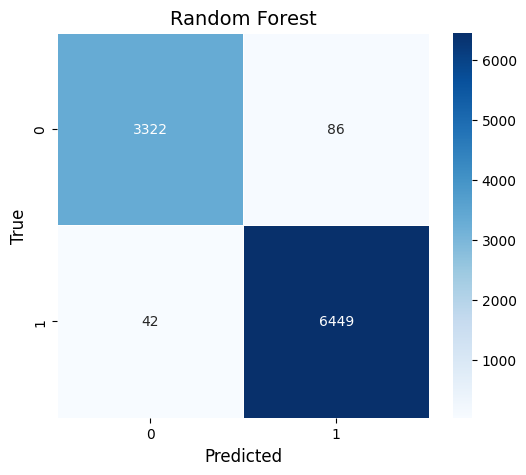

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(x_train, y_train)

# Step 3: Predictions
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# Step 4: Evaluation
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], linewidths=0.5,)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Random Forest', fontsize=14)
plt.show()


Training Accuracy: 0.99
Test Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3408
           1       0.99      0.99      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.98      0.99      9899
weighted avg       0.99      0.99      0.99      9899



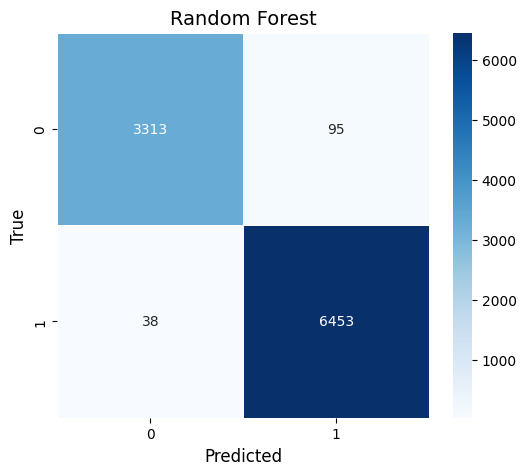

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=7
)

# Step 2: Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=7,
    n_jobs=-1
)
rf_model.fit(x_train, y_train)

# Step 3: Predictions
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# Step 4: Evaluation
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], linewidths=0.5,)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Random Forest', fontsize=14)
plt.show()


Training Accuracy: 0.99
Test Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3408
           1       0.98      0.99      0.99      6491

    accuracy                           0.98      9899
   macro avg       0.99      0.98      0.98      9899
weighted avg       0.98      0.98      0.98      9899



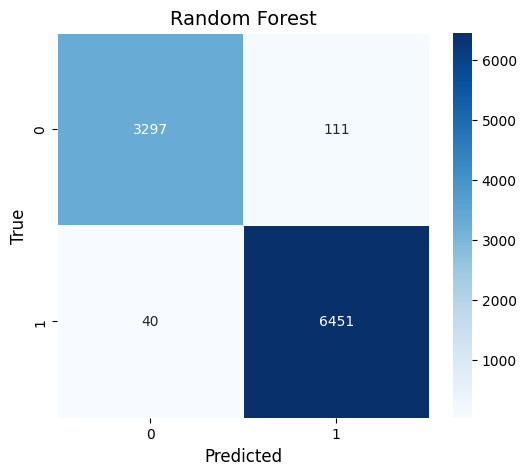

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=123
)

# Step 2: Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=123,
    n_jobs=-1
)
rf_model.fit(x_train, y_train)

# Step 3: Predictions
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

# Step 4: Evaluation
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], linewidths=0.5,)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Random Forest', fontsize=14)
plt.show()


In [ ]:
#Compiled result using 7, 42 and 123 seed values
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Seeds to evaluate
seeds = [7, 42, 123]

results = []

for seed in seeds:
    # Train-test split using current seed
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=seed
    )

    # Initialize Random Forest with consistent hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=seed,
        n_jobs=-1
    )

    # Train model
    rf_model.fit(x_train, y_train)

    # Predict on test set
    y_test_pred = rf_model.predict(x_test)

    # Calculate high-precision accuracy
    acc = accuracy_score(y_test, y_test_pred)

    # Store results
    results.append([seed, acc])

# Convert results to dataframe
df_rf = pd.DataFrame(results, columns=["Seed", "Accuracy"])

# Display more decimal places
pd.set_option('display.precision', 10)

print("\nRandom Forest Accuracies Across Seeds:")
print(df_rf)

# Optional — Summary statistics
summary = df_rf['Accuracy'].agg(['mean', 'std', 'min', 'max'])
print("\nSummary Statistics:")
print(summary)



Random Forest Accuracies Across Seeds:
   Seed      Accuracy
0     7  0.9865642994
1    42  0.9870694009
2   123  0.9847459339

Summary Statistics:
mean    0.9861265448
std     0.0012220256
min     0.9847459339
max     0.9870694009
Name: Accuracy, dtype: float64


**XGBoost**

Training Accuracy: 0.65
Test Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3366
           1       0.66      1.00      0.80      6533

    accuracy                           0.66      9899
   macro avg       0.33      0.50      0.40      9899
weighted avg       0.44      0.66      0.52      9899



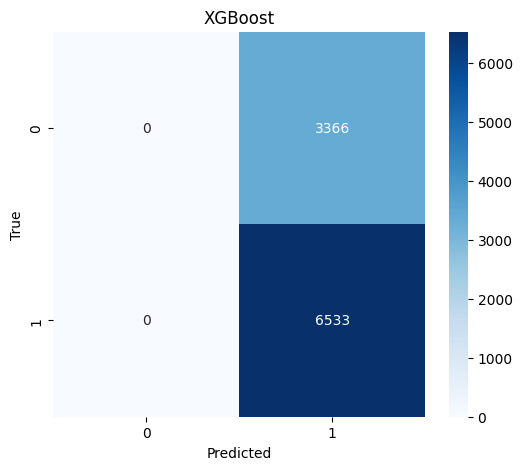

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the dataset
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Step 1: Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, max_depth=3, learning_rate=0.001)

xgb_model.fit(x_train, y_train)

# Step 3: Make predictions
y_train_pred = xgb_model.predict(x_train)
y_test_pred = xgb_model.predict(x_test)

# Step 4: Evaluate
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Step 5: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost')
plt.show()


**Logistic Regression**

Training Accuracy (Logistic Regression): 0.88
Validation Accuracy (Logistic Regression): 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      3366
           1       0.90      0.92      0.91      6533

    accuracy                           0.88      9899
   macro avg       0.87      0.86      0.87      9899
weighted avg       0.88      0.88      0.88      9899



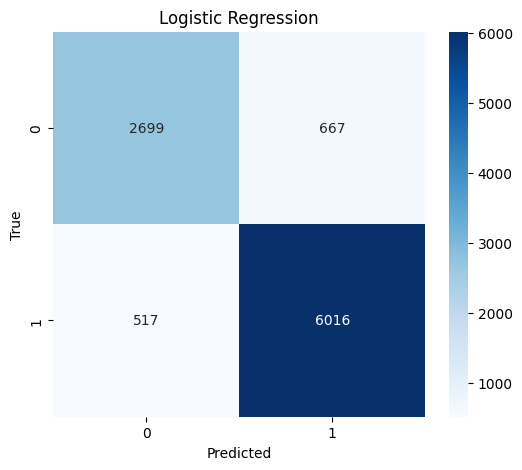

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Encode features same as CNN
x_encoded = pd.get_dummies(x)

# Step 2: Train-Test Split same as CNN
x_train, x_val, y_train, y_val = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Step 3: Scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Step 4: Initialize and train Logistic Regression
logreg = LogisticRegression(max_iter=2000, penalty='l1', solver='saga')
logreg.fit(x_train_scaled, y_train)

# Step 5: Predictions
y_train_pred = logreg.predict(x_train_scaled)
y_val_pred = logreg.predict(x_val_scaled)

# Step 6: Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy (Logistic Regression): {train_accuracy:.2f}")
print(f"Validation Accuracy (Logistic Regression): {val_accuracy:.2f}")

# Step 7: Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Step 8: Confusion Matrix Plot
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_val),
            yticklabels=np.unique(y_val))
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

# ---------------------------------------------------------------
# 1. ANN Predictions
# ---------------------------------------------------------------
y_test_pred_ann = (model.predict(x_test) > 0.5).astype(int).ravel()
ann_accuracy = accuracy_score(y_test, y_test_pred_ann)

# ---------------------------------------------------------------

# 2. CNN Predictions
# ---------------------------------------------------------------

# reshape test data for CNN input
x_test_cnn = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)

# generate predictions
y_test_pred_cnn = (model_cnn.predict(x_test_cnn) > 0.5).astype(int).ravel()

cnn_accuracy = accuracy_score(y_test, y_test_pred_cnn)

# ---------------------------------------------------------------
# 3. Decision Tree Predictions
# ---------------------------------------------------------------
dt_pred = dt_model.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

# ---------------------------------------------------------------
# 4. Random Forest Predictions
# ---------------------------------------------------------------
rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# ---------------------------------------------------------------
# 5. Logistic Regression Predictions

x_test_scaled = scaler.transform(x_test)
logreg_pred = logreg.predict(x_test_scaled)
logreg_accuracy = accuracy_score(y_test, logreg_pred)


# ---------------------------------------------------------------
# 6. XGBoost Predictions
# ---------------------------------------------------------------
xgb_pred = xgb_model.predict(x_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

# ---------------------------------------------------------------
# 7. Stacking Predictions
# ---------------------------------------------------------------
stack_pred = stacking_classifier.predict(x_test)
stacking_accuracy = accuracy_score(y_test, stack_pred)

# ---------------------------------------------------------------
# 8. Create Comparison Table
# ---------------------------------------------------------------
results = {
    "Model": [
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "XGBoost",
        "ANN",
        "CNN",
        "Stacking Ensemble"
    ],
    "Accuracy": [
        logreg_accuracy,
        dt_accuracy,
        rf_accuracy,
        xgb_accuracy,
        ann_accuracy,
        cnn_accuracy,
        stacking_accuracy
    ]
}

results_df = pd.DataFrame(results)

print(results_df)


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                 Model  Accuracy
0  Logistic Regression  0.880392
1        Decision Tree  0.991312
2        Random Forest  0.992929
3              XGBoost  0.659966
4                  ANN  0.991312
5                  CNN  0.991312
6    Stacking Ensemble  0.991110


# **95% Confidence Interval**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metric_ci(y_true, y_pred, metric_fn, n_bootstrap=2000, ci=0.95):
    n = len(y_true)
    stats = []

    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))

    lower = np.percentile(stats, ((1-ci)/2)*100)
    upper = np.percentile(stats, (1-(1-ci)/2)*100)

    return np.mean(stats), lower, upper


In [ ]:
# 1. Create predictions for every model
y_test_pred_ann = (model.predict(x_test) > 0.5).astype(int).ravel()
y_test_pred_cnn = (model_cnn.predict(x_test_cnn) > 0.5).astype(int).ravel()
dt_pred = dt_model.predict(x_test)
rf_pred = rf_model.predict(x_test)
logreg_pred = logreg.predict(x_test_scaled)   # if scaling used
xgb_pred = xgb_model.predict(x_test)
y_test_pred_stack = stacking_classifier.predict(x_test)  # ✅ FIXED

# 2. Store in dictionary
models = {
    "Logistic Regression": logreg_pred,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "ANN": y_test_pred_ann,
    "CNN": y_test_pred_cnn,
    "Stacking Ensemble": y_test_pred_stack
}


results = []

for name, preds in models.items():
    acc, acc_l, acc_u = metric_ci(y_test.values, preds, accuracy_score)
    prec, prec_l, prec_u = metric_ci(y_test.values, preds, lambda y, p: precision_score(y, p, zero_division=0))
    rec, rec_l, rec_u = metric_ci(y_test.values, preds, recall_score)
    f1, f1_l, f1_u = metric_ci(y_test.values, preds, f1_score)

    results.append([name,
                    acc, acc_l, acc_u,
                    prec, prec_l, prec_u,
                    rec, rec_l, rec_u,
                    f1, f1_l, f1_u])


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
import pandas as pd

columns = [
    "Model",
    "Accuracy", "Acc_CI_Lower", "Acc_CI_Upper",
    "Precision", "Prec_CI_Lower", "Prec_CI_Upper",
    "Recall", "Rec_CI_Lower", "Rec_CI_Upper",
    "F1-score", "F1_CI_Lower", "F1_CI_Upper"
]

results_df = pd.DataFrame(results, columns=columns)
print(results_df)


                 Model  Accuracy  Acc_CI_Lower  Acc_CI_Upper  Precision  \
0  Logistic Regression  0.880353      0.874227      0.886756   0.900142   
1        Decision Tree  0.991314      0.989494      0.993030   0.987279   
2        Random Forest  0.992943      0.991211      0.994545   0.990891   
3              XGBoost  0.659875      0.650871      0.669666   0.659988   
4                  ANN  0.991318      0.989393      0.993131   0.987017   
5                  CNN  0.991310      0.989494      0.993030   0.987007   
6    Stacking Ensemble  0.991086      0.989191      0.992828   0.987011   

   Prec_CI_Lower  Prec_CI_Upper    Recall  Rec_CI_Lower  Rec_CI_Upper  \
0       0.892701       0.907514  0.920897      0.914361      0.927343   
1       0.984517       0.989898  0.999692      0.999229      1.000000   
2       0.988494       0.992936  0.998443      0.997393      0.999375   
3       0.650366       0.669361  1.000000      1.000000      1.000000   
4       0.984229       0.989788  1

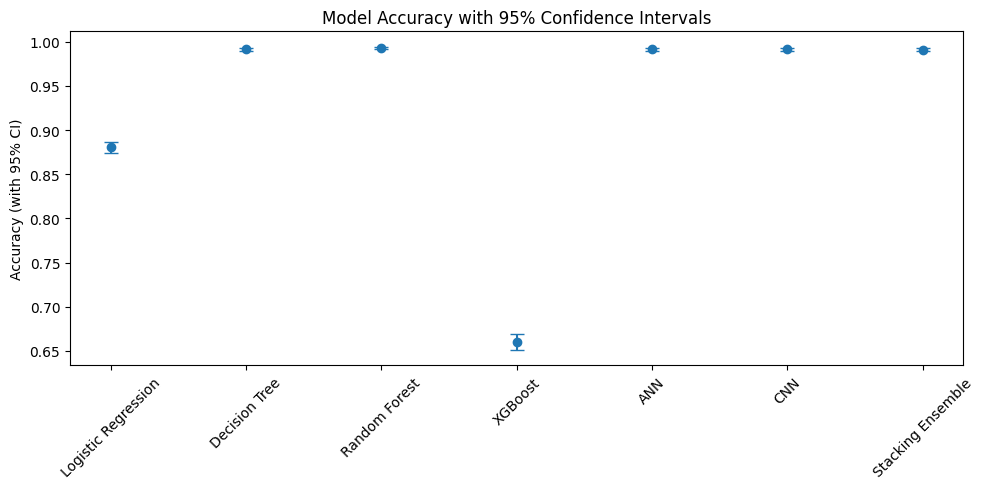

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.errorbar(
    results_df["Model"],
    results_df["Accuracy"],
    yerr=[
        results_df["Accuracy"] - results_df["Acc_CI_Lower"],
        results_df["Acc_CI_Upper"] - results_df["Accuracy"]
    ],
    fmt='o',
    capsize=5,
    markersize=6
)

plt.xticks(rotation=45)
plt.ylabel("Accuracy (with 95% CI)")
plt.title("Model Accuracy with 95% Confidence Intervals")
plt.tight_layout()
plt.show()


**95% CI for top 3 models using 7, 42 and 123 seed value**

In [ ]:
import pandas as pd
import numpy as np

data = {
    "Model": ["Stacking", "Stacking", "Stacking",
              "Decision Tree", "Decision Tree", "Decision Tree",
              "Random Forest", "Random Forest", "Random Forest"],

    "Seed": [42, 7, 123, 42, 7, 123, 42, 7, 123],

    "Accuracy": [
        0.9910091928, 0.9901000101, 0.9880796040,
        0.9910091928, 0.9903020507, 0.9884836852,
        0.9870694009, 0.9865642994, 0.9847459339
    ],

    "Precision": [0.99, 0.99, 0.99,
                  0.99, 0.99, 0.99,
                  0.99, 0.99, 0.99],

    "Recall": [0.99, 0.99, 0.98,
               0.99, 0.99, 0.98,
               0.98, 0.98, 0.98],

    "F1": [0.99, 0.99, 0.99,
           0.99, 0.99, 0.99,
           0.99, 0.99, 0.98]
}

df = pd.DataFrame(data)

metrics = ["Accuracy", "Precision", "Recall", "F1"]
models = df["Model"].unique()
results = []

for model in models:
    temp = df[df["Model"] == model]
    n = len(temp)
    row = {"Model": model}

    for m in metrics:
        mean = temp[m].mean()
        sd = temp[m].std()
        ci_low = mean - 1.96 * (sd / np.sqrt(n))
        ci_high = mean + 1.96 * (sd / np.sqrt(n))

        row[f"{m}_Mean"] = mean
        row[f"{m}_SD"] = sd
        row[f"{m}_CI_Lower"] = ci_low
        row[f"{m}_CI_Upper"] = ci_high

    results.append(row)

summary_df = pd.DataFrame(results)
pd.set_option("display.precision", 10)
print(summary_df)


           Model  Accuracy_Mean   Accuracy_SD  Accuracy_CI_Lower  \
0       Stacking   0.9897296023  0.0014995079       0.9880327493   
1  Decision Tree   0.9899316429  0.0013028617       0.9884573161   
2  Random Forest   0.9861265447  0.0012220256       0.9847436926   

   Accuracy_CI_Upper  Precision_Mean      Precision_SD  Precision_CI_Lower  \
0       0.9914264553            0.99  1.3597399555e-16                0.99   
1       0.9914059697            0.99  1.3597399555e-16                0.99   
2       0.9875093969            0.99  1.3597399555e-16                0.99   

   Precision_CI_Upper   Recall_Mean     Recall_SD  Recall_CI_Lower  \
0                0.99  0.9866666667  0.0057735027     0.9801333333   
1                0.99  0.9866666667  0.0057735027     0.9801333333   
2                0.99  0.9800000000  0.0000000000     0.9800000000   

   Recall_CI_Upper       F1_Mean             F1_SD   F1_CI_Lower  F1_CI_Upper  
0           0.9932  0.9900000000  1.3597399555e-16  0

# **McNemar Tests**

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

models = {
    "Logistic Regression": logreg_pred,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "ANN": y_test_pred_ann,
    "CNN": y_test_pred_cnn,
    "Stacking Ensemble": y_test_pred_stack
}


In [ ]:
def run_mcnemar_test(model1, model2, y_true, preds1, preds2):
    # b01 = model1 wrong, model2 correct
    b01 = np.sum((preds1 != y_true) & (preds2 == y_true))
    # b10 = model1 correct, model2 wrong
    b10 = np.sum((preds1 == y_true) & (preds2 != y_true))

    table = [[0, b01],
             [b10, 0]]

    result = mcnemar(table, exact=False, correction=True)

    print(f"\n===== McNemar Test: {model1} vs {model2} =====")
    print(f"b01 = {b01}, b10 = {b10}")
    print(f"Test statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")

    if result.pvalue < 0.05:
        print("➡ Significant difference (p < 0.05)")
    else:
        print("➡ NO significant difference (p ≥ 0.05)")


In [ ]:
run_mcnemar_test("Random Forest", "XGBoost", y_test.values, rf_pred, xgb_pred)
run_mcnemar_test("Random Forest", "Stacking Ensemble", y_test.values, rf_pred, y_test_pred_stack)
run_mcnemar_test("XGBoost", "Stacking Ensemble", y_test.values, xgb_pred, y_test_pred_stack)
run_mcnemar_test("ANN", "CNN", y_test.values, y_test_pred_ann, y_test_pred_cnn)
run_mcnemar_test("Decision Tree", "Random Forest", y_test.values, dt_pred, rf_pred)



===== McNemar Test: Random Forest vs XGBoost =====
b01 = 10, b10 = 3306
Test statistic: 3274.132991556092
p-value: 0.0
➡ Significant difference (p < 0.05)

===== McNemar Test: Random Forest vs Stacking Ensemble =====
b01 = 10, b10 = 28
Test statistic: 7.605263157894737
p-value: 0.0058198169540098505
➡ Significant difference (p < 0.05)

===== McNemar Test: XGBoost vs Stacking Ensemble =====
b01 = 3280, b10 = 2
Test statistic: 3272.0076173065204
p-value: 0.0
➡ Significant difference (p < 0.05)

===== McNemar Test: ANN vs CNN =====
b01 = 0, b10 = 0
Test statistic: inf
p-value: 0.0
➡ Significant difference (p < 0.05)

===== McNemar Test: Decision Tree vs Random Forest =====
b01 = 26, b10 = 10
Test statistic: 6.25
p-value: 0.01241933065155227
➡ Significant difference (p < 0.05)


# **TabNet**

In [ ]:
pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00


epoch 0  | loss: 0.45176 | val_0_accuracy: 0.83907 |  0:00:06s
epoch 10 | loss: 0.05615 | val_0_accuracy: 0.98838 |  0:01:08s
epoch 20 | loss: 0.04752 | val_0_accuracy: 0.98848 |  0:02:15s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_accuracy = 0.98869
TabNet Test Accuracy: 0.988685725830892

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3408
           1       0.98      1.00      0.99      6491

    accuracy                           0.99      9899
   macro avg       0.99      0.98      0.99      9899
weighted avg       0.99      0.99      0.99      9899



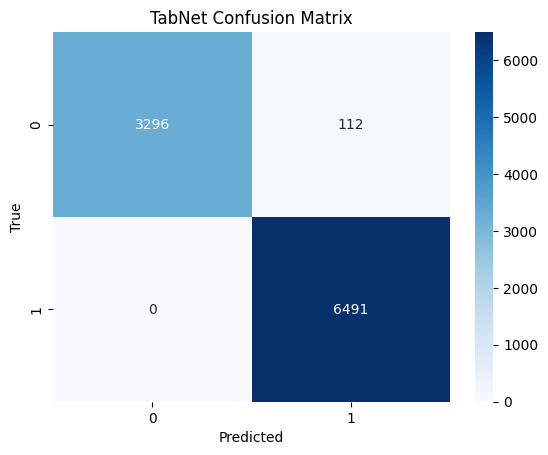

In [ ]:
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch

import numpy as np

X_train_tab = np.array(x_train, dtype=np.float32)
X_test_tab  = np.array(x_test, dtype=np.float32)
y_train_tab = np.array(y_train, dtype=np.int64)
y_test_tab  = np.array(y_test, dtype=np.int64)

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

tabnet = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',
    seed=42,
    verbose=10
)

tabnet.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_tab = tabnet.predict(X_test_tab)

print("TabNet Test Accuracy:", accuracy_score(y_test_tab, y_pred_tab))
print("\nClassification Report:")
print(classification_report(y_test_tab, y_pred_tab))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_tab, y_pred_tab)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TabNet Confusion Matrix")
plt.show()
